In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('modules')
import numpy as np
from numpy import sum, exp, pi, asarray

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy import units as u

from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline

import pandas as pd

from calculations_module import *
# from cosmology_module import Cosmology_function
# from variance_module import Variance
# from ratefunction_module import *
from criticalpoints_module import *
from computePDF_module import *
from variables_module import *

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The steps involved are as follows:

Step 1: Get the cosmological parameters

Step 2: Calculate the rate function and find the critical points

Step 3: Calculate the scaled CGF

step 4: Apply inverse lalpace transform on this to get the PDF

In the below code the critical points could be plotted if needed and the SCGf could also be plotted if needed by seeting the corresponding flags.

The l1 is obtained from the simulation PDF

Loading parameters..
the source redshift is:  1.2179
the chistar is:  2699.7527957304887
the number of planes being used is:  21
The mass map variance from theory is:  1.2779518453820329e-05
 
Now computing for the takahashi's simlation..
the source redshift for which the file is being loaded is:  1.2179
the takahashi file being loaded is:  /feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs18.mag.dat
nside:4096 npix:201326592
file opened!
Smoothing operations done!
The redshift is: 1.2179
The theta is: 15.0
Variance: 1.3375505784630105e-05
The driving parameter is:  0.9554418845607595
 
Calculating the critical points in each plane..
Setting ngrid = 75. Increase this for more accuracy, but note that computation becomes slower!
The approximate critical points at redshift z:  0.02  are:  [1392.17652691 -658.18280395]
The approximate critical points at redshift z:  0.04  are:  [1051.69178335 -514.46273023]
The approximate critical points at redshift z:  0.06  a

/tmp/ipykernel_1770511/3327336381.py:79: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(gs[0, 0])


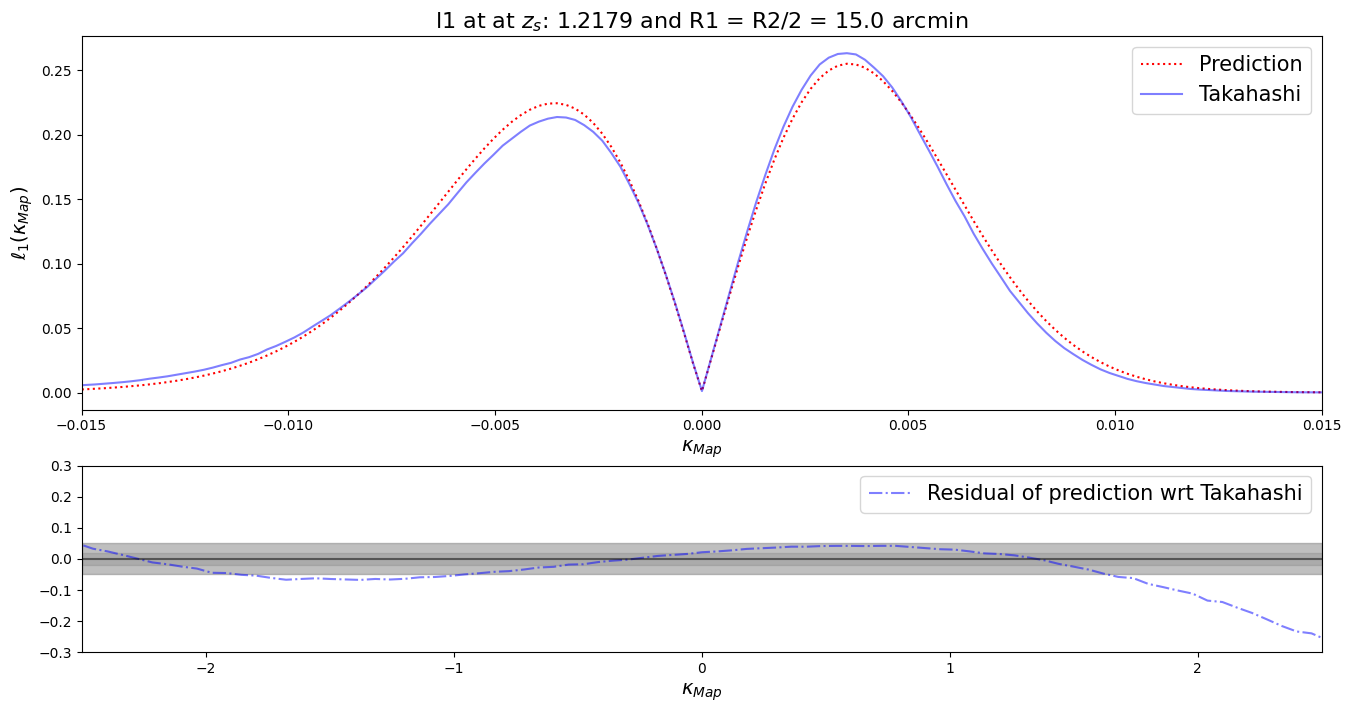

     Metric  Prediction PDF  Simulation PDF
0      Mean   -3.634627e-09   -5.450747e-09
1  Variance    1.337536e-05    1.337950e-05
2  Skewness   -5.575614e+01   -1.104438e+02
3  Kurtosis    2.339309e-01    8.394793e-01
4      Norm    9.999998e-01    9.999999e-01
Loading parameters..
the source redshift is:  1.2179
the chistar is:  2699.7527957304887
the number of planes being used is:  21
The mass map variance from theory is:  1.1247867729841496e-05
 
Now computing for the takahashi's simlation..
the source redshift for which the file is being loaded is:  1.2179
the takahashi file being loaded is:  /feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs18.mag.dat
nside:4096 npix:201326592
file opened!


In [3]:
#######
# Takahashi simulation parameters
#######
h = 0.7
Ob = 0.046
Oc = 0.233
mnu = 0.0
Om = Ob + Oc
ns = 0.97
As_ = 2.10
# As = As_ * 1e-9
Omnu = mnu / 93.14 / h / h
Ol = 1.0 - Om
Oc = Om - Ob - Omnu
H0 = 100.
speed_light = 299792.458

# Redshift values for Takahashi simulation
tk_zs = np.array([0.0506, 0.5078, 1.0334, 1.2179, 1.4230, 1.6528, 1.9121, 2.0548, 2.3704, 3.9309, 5.3423])


zs_ = [tk_zs[3], tk_zs[4], tk_zs[7]]

theta1_input_ = [15., 18, 20]

for zs_counter in range(len(zs_)):
    for theta1_counter in range(len(theta1_input_)):
        zs = zs_[zs_counter]
        theta1_input = theta1_input_[theta1_counter]

        print("Loading parameters..")
        # Initialize variables for simulation
        variables = VariablesGenerator(h, H0, Ob, Oc, mnu, ns, As_, zs, theta1_input)
        
        # Flag to load Takahashi simulation data
        load_takahashi = True
        if load_takahashi:
            print(" ")
            print("Now computing for the takahashi's simlation..") 
            from takahashi_loader import * 
            nside = 2048 # HEALPix parameter for angular resolution
            loader = TakahashiLoader()
            variance_takahashi, kmap1, kmap2 = loader.run_loader(theta1_input, nside, zs, 8)
            k_massmap_simulation = kmap2 - kmap1
            variables.recal_value = variables.sigmasq_map/variance_takahashi
            print("The driving parameter is: ", variables.recal_value)
            
            # Calculate the probability density function (PDF) of the simulation
            pdf_simulation, bin_edges = np.histogram(k_massmap_simulation, bins=300, density=True)
            kappa_sim =  0.5 * (bin_edges[:-1] + bin_edges[1:])

        print(" ")
        print("Calculating the critical points in each plane..")
        criticalpoints = CriticalPointsFinder(variables, ngrid=75, plot=False)
        critical_values = []
        for i in range(1,8):
            critical_values.append(criticalpoints.get_critical_points(1*i*0.02))
        plt.show()
        critical_values = np.array(critical_values)
        smallest_pair = find_smallest_pair(critical_values)
        print("Smallest pair(s) of critical points are:", smallest_pair)
        # plt.plot(critical_values[:,0],critical_values[:,1])

        print(" ")
        print("Getting the PDF..")
        variables.lambdas = np.linspace(smallest_pair[0][1]+30, smallest_pair[0][0]-100, 20)
        computed_PDF = computePDF(variables, plot_scgf=False)
        pdf_values, kappa_values = computed_PDF.pdf_values, computed_PDF.kappa_values

        pdf_spline = CubicSpline(kappa_values,pdf_values)
        pdf_theory = pdf_spline(kappa_sim)

        l1_pred = get_l1_from_pdf(pdf_theory, kappa_sim)
        l1_sim = get_l1_from_pdf(pdf_simulation, kappa_sim)

        fig, axs = plt.subplots(2,1, figsize=(16,8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

        plt.subplot(gs[0, 0])
        plt.plot(kappa_sim,l1_pred, ls=":", c='r', label='Prediction')
        plt.plot(kappa_sim, l1_sim, label="Takahashi",c='b', alpha=0.5)
        plt.legend()
        plt.xlabel(r'$\kappa_{Map}$', size = 14)
        plt.ylabel(r'$\ell_1(\kappa_{Map})$', size = 14)
        plt.legend(fontsize=15)
        plt.xlim(-0.015,0.015)
        plt.title(r"l1 at at $z_s$: " + str(zs) + " and R1 = R2/2 = " + str(theta1_input) + " arcmin" , fontsize=16)

        xlim_min = -0.0125
        xlim_max = 0.008

        plt.subplot(gs[1, 0])
        plt.plot(kappa_sim/np.sqrt(variance_takahashi), (l1_sim-l1_pred)/l1_sim, label="Residual of prediction wrt Takahashi", ls="-.",c='b', alpha=0.5)
        plt.legend(fontsize=15)
        plt.xlabel(r'$\kappa_{Map}$', size = 14)
        # plt.ylabel(r'$\frac{P(\mathrm{\kappa_{Map}}) - P_{prediction}(\mathrm{\kappa_{Map}})}{P_{prediction}(\mathrm{\kappa_{Map}})}$', size=14)
        plt.ylim(-0.30,0.30)
        plt.axhline(0,0,1,color='k',alpha=0.5)
        plt.axhspan(-0.02,0.02,0,1,alpha=0.3,color='grey')
        plt.axhspan(-0.05,0.05,0,1,alpha=0.5,color='grey')
        plt.xlim(-2.5,2.5)
        plt.show()

        # Calculate statistical moments
        pred_stat = get_moments(kappa_sim, pdf_theory)
        sim_stat = get_moments(kappa_sim, pdf_simulation)
        # Compare prediction and simulation
        data = {
        "Metric": ["Mean", "Variance", "Skewness", "Kurtosis","Norm"],
        "Prediction PDF": pred_stat,
        "Simulation PDF": sim_stat,
        }
        df = pd.DataFrame(data)
        print(df)
        
        zs_formatted = str(zs).replace('.', '_')

        # Format the filename to include zs and theta1_input
        filename = f"theory_values_{zs_formatted}_{theta1_input}"

        # Format the content to save the calculated values
        content = f"""
        Computed Values:
        - L1 Prediction: {l1_pred}
        - PDF Prediction: {pdf_theory}
        - kappa: {kappa_sim}
        """
        theory_data = np.array([pdf_theory, l1_pred, kappa_sim])
        
        cwd = os.getcwd()
        # Path to save the file
        file_path = cwd+f"/paper/data/{filename}"
        np.save(file_path, theory_data.T)
        